## Training for the result all chrs. (Aug 27th)
Chr22 we got the result, now we need to do the same training on the result. 
chr22 only contians a little bit, 

In [1]:
import numpy as np
import pandas as pd
import magenpy as mgp
import viprs as vp
import subprocess
import io
from viprs.eval.metrics import r2 
from viprs.eval.metrics import pearson_r
from data.utils.Simulate_training import ELBO_plot
from data.utils.Simulate_training import *
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# change the plink1.9 and plink2 path to local path
mgp.set_option("plink2_path", "/home/mcb/users/yzhu439/local/bin/plink2_file/plink2")
mgp.set_option("plink1.9_path","/home/mcb/users/yzhu439/local/bin/plink_linux_x86_64/plink" )
mgp.print_options()

-> Section: USER
---> plink2_path: /home/mcb/users/yzhu439/local/bin/plink2_file/plink2
---> plink1.9_path: /home/mcb/users/yzhu439/local/bin/plink_linux_x86_64/plink
-> Section: DEFAULT
---> plink1.9_path: plink
---> plink2_path: plink2


<h3>Create files that can extract relative chromosome. </h3>
There will have files contains snps for each chr. 

<h3> I need to create a file to help me to extract all snps for different chr respectivley chr 1-21 </h3> 
 
chr23: gender  
chr22: already created and tested  
chr1-21: I need to extract them from <code>merge10 binary files</code>. It contains <code> 2706 samples </code>, and separte into 0.8:0.2, train: validation.  

Example for eactract chr 22:  
1. Create the .txt file with SNPs from <code> chr22,21,20 from merge10.bim </code>file. And sorted them according the the SNP names (code cell is below)
2. Use plink command to filter the binary file sets based on this .txt SPNs file and produce 3 new .bed+ .fam+ .bim files. Command:  
Under the folder <code> /CMAll_qced/chr222120 </code>, then run:  
<code > plink --bfile ../merged10 --extract ../ALL_chr222120.txt  
--make-bed --out ALL_chr222120 </code>
3. Since if we don't use plink backend in mgp, no need as to update the CM. (The plink needs the old version that haven't installed.)

In [5]:
merge10 = pd.read_csv("CMAll_qced/merged10.bim", sep="\t", header=None)

# ALL222120 = merge10[merge10[0].isin([22, 21, 20])][1]  # [1] means the snp_IDs
# ALL222120_sort = ALL222120.sort_values()
# ALL222120_sort.to_csv("CMAll_qced/ALL_chr222120.txt", header=False,
#                       index=False, sep="\t")

for i in range(1, 22):
    one_chr = merge10[merge10[0].isin([i])][1]  # [1] means the snp_IDs
    one_chr_sort = one_chr.sort_values()
    chr_filename = "CMAll_qced/ALL_chr"+ str(i)+ ".txt"
    one_chr_sort.to_csv(chr_filename, header=False,
                      index=False, sep="\t")

<h3>Create and run the .sh file to got  </h3>

use <code>chmod +x chro.sh </code> In <code> CMAll_qced/extract_chromosomes.sh </code>  
to get binary files for each chr.


In [9]:
#just a check for snps in chr.

check_bim_file  = pd.read_csv("CMAll_qced/binary_chr2/ALL_chr2.bim", sep="\t",header=None)
check_bim_file

,0,1,2,3,4,5
0,2,rs2176413,1.73541,0,A,G
1,2,rs11127467,0.00000,12994,G,C
2,2,rs10181821,0.00000,15703,G,A
3,2,rs7594567,0.00000,21833,C,G
4,2,rs13423995,1.77944,23012,G,A
...,...,...,...,...,...,...
107447,2,rs6740738,0.00000,243007368,C,A
107448,2,rs11899408,0.00000,243014630,G,A
107449,2,rs4973686,0.00000,243020723,A,G
107450,2,rs4973649,0.00000,243034519,G,T


<h3>Train for those chromosomes respectivley  </h3>


Train on chr1

In [10]:
np.random.seed(1235)
# paths need to be updated for different chr. 
chr_bed_filepath = "CMAll_qced/binary_chr1/ALL_chr1"
sumstats_path = "CMAll_qced/binary_chr1/real_chr1.sumstats"
output_LD_dirpath = "CMAll_qced/binary_chr1/"   # ld/chr1 would been built there 
ELBO_plot_path = "Real_phe_expr/ELBO_plots/real_ALL_chr1.png"
M_fixed_paras = {'pi':0.05, 'sigma_epsilon':  0.70}

# real_phe for 2706 samples
realA22_gdl = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

realA22Train_gdl, realA22Val_gdl = realA22_gdl.split_by_samples(proportions=[.8, .2])

realA22Train_gdl.perform_gwas()
realA22Train_gdl.to_summary_statistics_table().to_csv(
    sumstats_path, sep="\t", index=False
)


realA22Train_gdl.compute_ld(estimator='sample',
                output_dir=output_LD_dirpath)


print(realA22Train_gdl.sample_size)
print(realA22Val_gdl.sample_size)

> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 101
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2178
528


In [11]:
v = vp.VIPRS(realA22Train_gdl, fix_params = M_fixed_paras) 
# v = vp.VIPRS(realA22Train_gdl) 
# theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
# v.initialize(theta_0=theta_0)
v.fit()

> Initializing model parameters
> Performing model fit...
> Using up to 1 threads.


  0%|          | 1/1000 [51:23<855:44:39, 3083.76s/it]/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Iteration 2: ELBO dropped from -2473.169297 to -2479.924093.
  """
 36%|███▌      | 362/1000 [24:12:44<42:40:21, 240.79s/it]  

Converged at iteration 363 || ELBO: -1916.987740
> Final ELBO: -1916.987740
> Estimated heritability: 0.492113
> Estimated proportion of causal variants: 0.050000


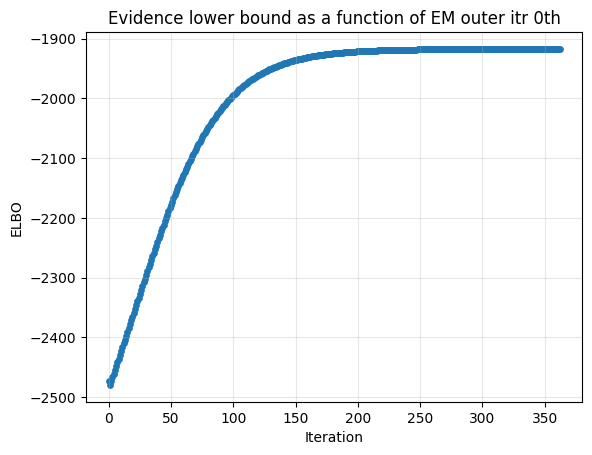

In [12]:
ELBO_plot(v.history['ELBO'], ELBO_plot_path,itr=0)


> Generating polygenic scores...
val R: -0.08523746826653496
> Generating polygenic scores...
train R: 0.6697385941517593
the Val_gdl real phe vs. predict phe


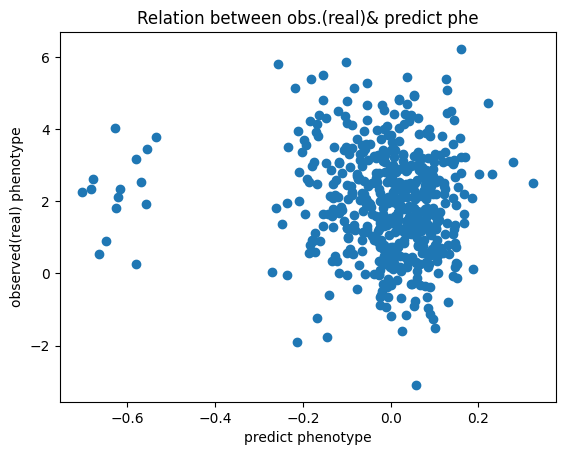

In [13]:
pred = v.predict(realA22Val_gdl)
print("val R:", pearson_r(pred, realA22Val_gdl.sample_table.phenotype))

pred_ytrain = v.predict(realA22Train_gdl)
print("train R:", pearson_r(pred_ytrain, realA22Train_gdl.sample_table.phenotype))

print("the Val_gdl real phe vs. predict phe")
plot_obs_vs_pred(realA22Val_gdl.sample_table.phenotype, pred)


Train on chr19 

In [14]:
np.random.seed(1235)
# paths need to be updated for different chr. 
# use to compute LD for training set.
chr_bed_filepath = "CMAll_qced/binary_chr19/ALL_chr19"
sumstats_path = "CMAll_qced/binary_chr19/real_chr19.sumstats"
output_LD_dirpath = "CMAll_qced/binary_chr19/"   # ld/chr1 would been built there 
ELBO_plot_path = "Real_phe_expr/ELBO_plots/real_ALL_chr19.png"
M_fixed_paras = {'pi':0.05, 'sigma_epsilon':  0.70}

# real_phe for 2706 samples
realA22_gdl_19 = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

realA22Train_gdl_19, realA22Val_gdl_19 = realA22_gdl_19.split_by_samples(proportions=[.8, .2])

realA22Train_gdl_19.perform_gwas()
realA22Train_gdl_19.to_summary_statistics_table().to_csv(
    sumstats_path, sep="\t", index=False
)


realA22Train_gdl_19.compute_ld(estimator='sample',
                output_dir=output_LD_dirpath)


print(realA22Train_gdl_19.sample_size)
print(realA22Val_gdl_19.sample_size)

> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 21
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2178
528


In [26]:
# read the LD
np.random.seed(1235)
# paths need to be updated for different chr. 
chr_bed_filepath = "CMAll_qced/binary_chr19/ALL_chr19"
sumstats_path = "CMAll_qced/binary_chr19/real_chr19.sumstats"
output_LD_dirpath = "CMAll_qced/binary_chr19/"   # ld/chr1 would been built there 
ELBO_plot_path = "Real_phe_expr/ELBO_plots/real_ALL_chr19.png"
M_fixed_paras = {'pi':0.05, 'sigma_epsilon':  0.70}

# real_phe for 2706 samples
realA22_gdl_19 = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

realA22Train_gdl_19, realA22Val_gdl_19 = realA22_gdl_19.split_by_samples(proportions=[.8, .2])

realA22Train_gdl_19.perform_gwas()
realA22Train_gdl_19.to_summary_statistics_table().to_csv(
    sumstats_path, sep="\t", index=False
)

realA22Train_gdl_19.read_ld("CMAll_qced/binary_chr19/ld/chr_19")


print(realA22Train_gdl_19.sample_size)
print(realA22Val_gdl_19.sample_size)

> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Reading LD matrix...
2178
528


In [27]:
v_19 = vp.VIPRS(realA22Train_gdl_19, fix_params = M_fixed_paras) 
# v = vp.VIPRS(realA22Train_gdl) 
# theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
# v.initialize(theta_0=theta_0)
v_19.fit()

> Initializing model parameters
> Loading LD matrices into memory...


> Performing model fit...
> Using up to 1 threads.


 23%|██▎       | 230/1000 [09:53<33:08,  2.58s/it] 

Converged at iteration 231 || ELBO: -2128.126713
> Final ELBO: -2128.126713
> Estimated heritability: 0.460898
> Estimated proportion of causal variants: 0.050000


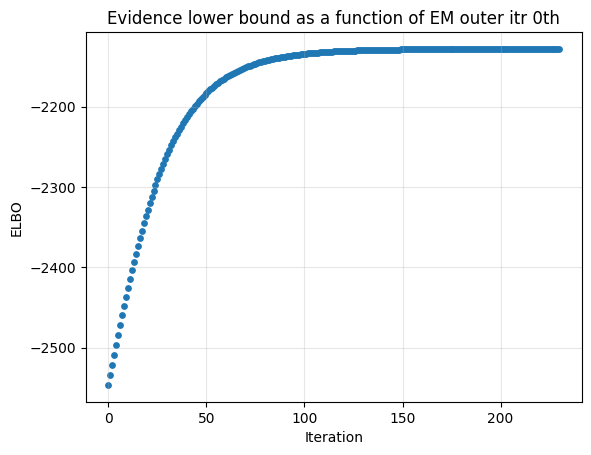

> Generating polygenic scores...
val R: 0.05284213609857501
> Generating polygenic scores...
train R: 0.05284213609857501
the Val_gdl real phe vs. predict phe


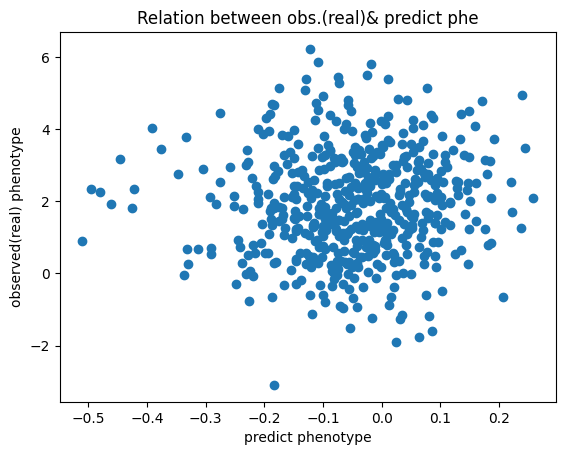

In [28]:
ELBO_plot(v_19.history['ELBO'], ELBO_plot_path,itr=0)


pred = v_19.predict(realA22Val_gdl_19)
print("val R:", pearson_r(pred, realA22Val_gdl_19.sample_table.phenotype))

pred_ytrain = v_19.predict(realA22Val_gdl_19)
print("train R:", pearson_r(pred_ytrain, realA22Val_gdl_19.sample_table.phenotype))

print("the Val_gdl real phe vs. predict phe")
plot_obs_vs_pred(realA22Val_gdl_19.sample_table.phenotype, pred)


Train on ch15-22 

For chr14, it is interrupted by ssh connection, maybe ld for it cannot be used directly.  (this maybe not used in later prediction test)  
chr15 work.  
chr16 interrupted by ssh disconnection, but use ld and gwas to fit. (not sure whether it is good)  
chr17 work


> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 32
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 18%|█▊        | 178/1000 [05:18<24:31,  1.79s/it]

Converged at iteration 179 || ELBO: -1984.762963
> Final ELBO: -1984.762963
> Estimated heritability: 0.485166
> Estimated proportion of causal variants: 0.050000


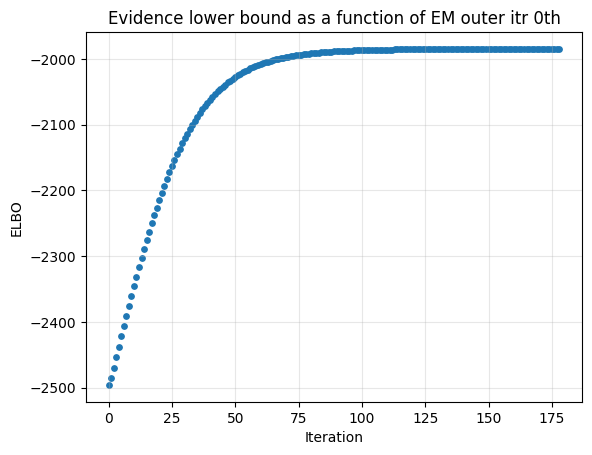

> Generating polygenic scores...
> Generating polygenic scores...
> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 38
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <finalize object at 0x7ff809e86de0; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 934, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'temp/ld_wwbki3b1'


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 18%|█▊        | 176/1000 [06:37<31:01,  2.26s/it]

Converged at iteration 177 || ELBO: -1957.014939
> Final ELBO: -1957.014939
> Estimated heritability: 0.495020
> Estimated proportion of causal variants: 0.050000


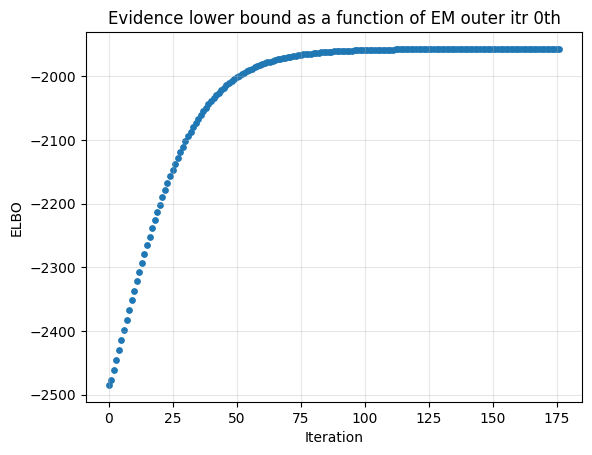

> Generating polygenic scores...
> Generating polygenic scores...
> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 21
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <finalize object at 0x7ff7d031bd60; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 934, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'temp/ld_2xob_hzu'


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 23%|██▎       | 230/1000 [03:00<10:04,  1.27it/s]

Converged at iteration 231 || ELBO: -2128.126713
> Final ELBO: -2128.126713
> Estimated heritability: 0.460898
> Estimated proportion of causal variants: 0.050000


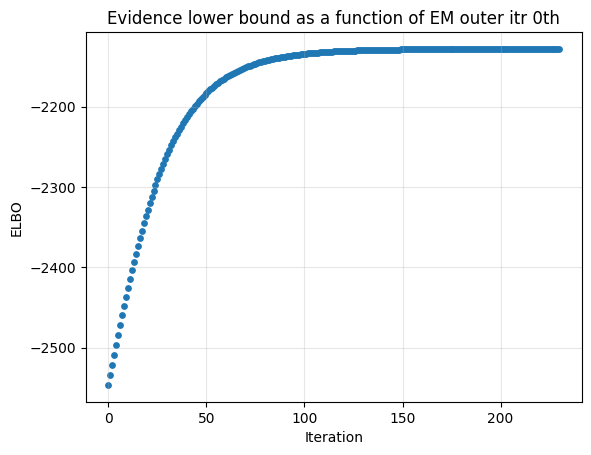

> Generating polygenic scores...
> Generating polygenic scores...
> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 33
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <finalize object at 0x7ff803c6ae50; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 934, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'temp/ld_t8lt6jst'


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 19%|█▉        | 190/1000 [16:09<1:08:51,  5.10s/it]

Converged at iteration 191 || ELBO: -1904.467564
> Final ELBO: -1904.467564
> Estimated heritability: 0.497419
> Estimated proportion of causal variants: 0.050000


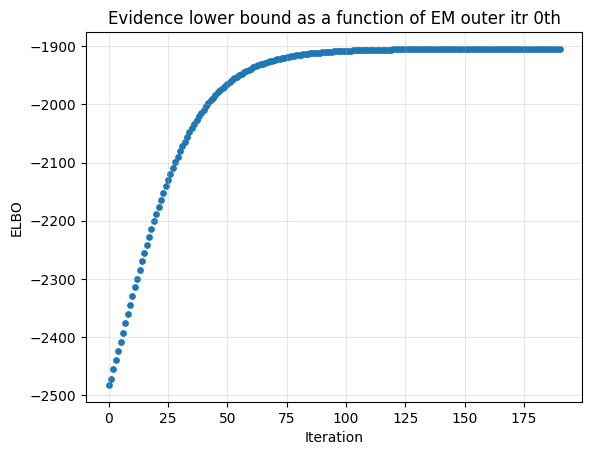

> Generating polygenic scores...
> Generating polygenic scores...
> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 19
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <finalize object at 0x7ff803c6af10; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 934, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'temp/ld_9pim7f_d'


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


100%|██████████| 1000/1000 [27:02<00:00,  1.62s/it]
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Maximum iterations reached without convergence. You may need to run the model for more iterations.


> Final ELBO: 9451953.204097
> Estimated heritability: 0.962317
> Estimated proportion of causal variants: 0.050000


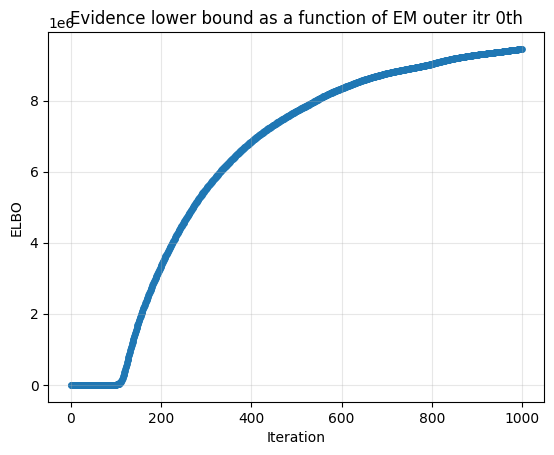

> Generating polygenic scores...
> Generating polygenic scores...
> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/array/routines.py:318: PerformanceWarning: Increasing number of chunks by factor of 18
  axes=(left_axes, right_axes),
/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <finalize object at 0x7ff7ac621c70; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 934, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'temp/ld_jwuk2jg0'


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 16%|█▋        | 164/1000 [03:37<18:27,  1.32s/it]

Converged at iteration 165 || ELBO: -2469.668409
> Final ELBO: -2469.668409
> Estimated heritability: 0.357371
> Estimated proportion of causal variants: 0.050000


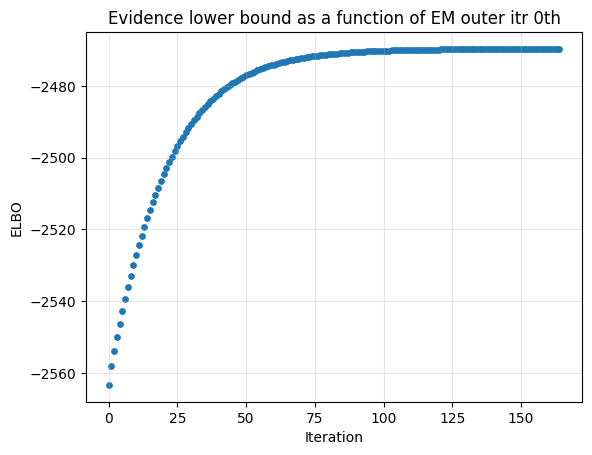

> Generating polygenic scores...
> Generating polygenic scores...


In [14]:
T_pred = np.zeros(2178)
V_pred = np.zeros(528)

for num_chr in range(17,23):
    np.random.seed(1235)
    # paths need to be updated for different chr. 
    # use to compute LD for training set.
    chr_bed_filepath = "CMAll_qced/binary_chr"+str(num_chr)+"/ALL_chr"+str(num_chr)
    sumstats_path = "CMAll_qced/binary_chr"+str(num_chr)+"/real_chr"+str(num_chr)+".sumstats"
    output_LD_dirpath = "CMAll_qced/binary_chr"+str(num_chr)+"/"   # ld/chr1 would been built there 
    ELBO_plot_path = "CMAll_qced/binary_chr"+str(num_chr)+"/ELBO.png"
    store_predVal = "CMAll_qced/binary_chr"+str(num_chr)+"/val_predict.npy"
    store_predTrain = "CMAll_qced/binary_chr"+str(num_chr)+"/train_predict.npy"
    # can use np.load(store_predVal) to get the array 
    M_fixed_paras = {'pi':0.05, 'sigma_epsilon':  0.70}

    # real_phe for 2706 samples
    gdl_chr = mgp.GWADataLoader(
        bed_files = chr_bed_filepath,
        # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
        phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    )
    #"Toy_example_expr/phenotype/shuffle500_phe.csv"

    Train_gdl_chr, Val_gdl_chr = gdl_chr.split_by_samples(proportions=[.8, .2])

    Train_gdl_chr.perform_gwas()
    Train_gdl_chr.to_summary_statistics_table().to_csv(
        sumstats_path, sep="\t", index=False
    )


    Train_gdl_chr.compute_ld(estimator='sample',
                    output_dir=output_LD_dirpath)
    
    v_chr = vp.VIPRS(Train_gdl_chr, fix_params = M_fixed_paras) 
    # v = vp.VIPRS(realA22Train_gdl) 
    # theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
    # v.initialize(theta_0=theta_0)
    v_chr.fit()

    ELBO_plot(v_chr.history['ELBO'], ELBO_plot_path,itr=0)
    Val_pred = v_chr.predict(Val_gdl_chr)
    np.save(store_predVal, Val_pred)
    V_pred = V_pred + Val_pred

    Train_pred = v_chr.predict(Train_gdl_chr)
    np.save(store_predTrain, Train_pred)
    T_pred = T_pred + Train_pred

    # pred = v_19.predict(realA22Val_gdl_19)
    # print("val R:", pearson_r(pred, realA22Val_gdl_19.sample_table.phenotype))

    # pred_ytrain = v_19.predict(realA22Val_gdl_19)
    # print("train R:", pearson_r(pred_ytrain, realA22Val_gdl_19.sample_table.phenotype))

    # print("the Val_gdl real phe vs. predict phe")
    # plot_obs_vs_pred(realA22Val_gdl_19.sample_table.phenotype, pred)
    

In [24]:
# add the validation together 
Total_trainPred = np.zeros(2178)
Total_ValPred = np.zeros(528)
for i in range(15, 23):
    if i==21 :
        continue
    store_predVal = "CMAll_qced/binary_chr"+str(i)+"/val_predict.npy"
    store_predTrain = "CMAll_qced/binary_chr"+str(i)+"/train_predict.npy"   
    t = np.load(store_predTrain)
    vpred = np.load(store_predVal)
    Total_trainPred = Total_trainPred + t
    Total_ValPred = Total_ValPred + vpred

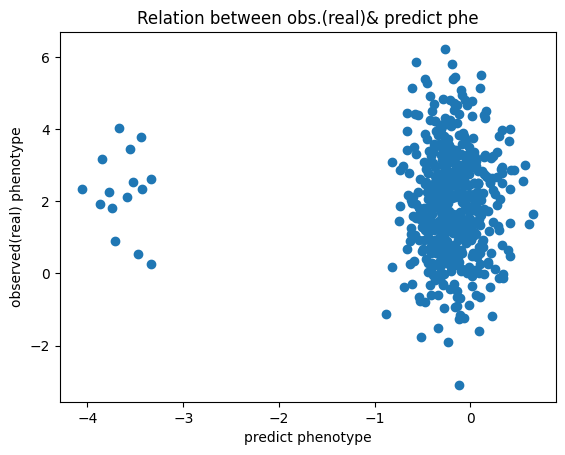

-0.03522857678671778

In [25]:
plot_obs_vs_pred(Val_gdl_chr.sample_table.phenotype, Total_ValPred)
pearson_r(Total_ValPred, Val_gdl_chr.sample_table.phenotype)

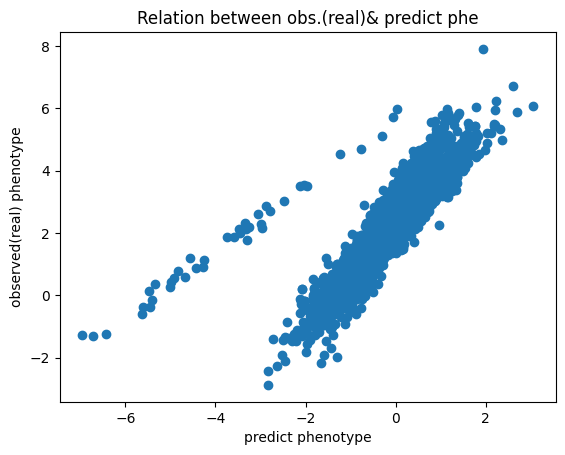

0.8231603323121675

In [26]:
plot_obs_vs_pred(Train_gdl_chr.sample_table.phenotype, Total_trainPred)
pearson_r(Total_trainPred, Train_gdl_chr.sample_table.phenotype)

When ssh disconnected suddenly. but LD and gwas already have :

> Reading BED file...
> Reading phenotype file...
> Reading summary statistics file...
> Harmonizing data...
> Reading LD matrix...
> Reading summary statistics file...
> Harmonizing data...
> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 20%|██        | 203/1000 [08:55<35:02,  2.64s/it]

Converged at iteration 204 || ELBO: -1977.783157
> Final ELBO: -1977.783157
> Estimated heritability: 0.483256
> Estimated proportion of causal variants: 0.050000


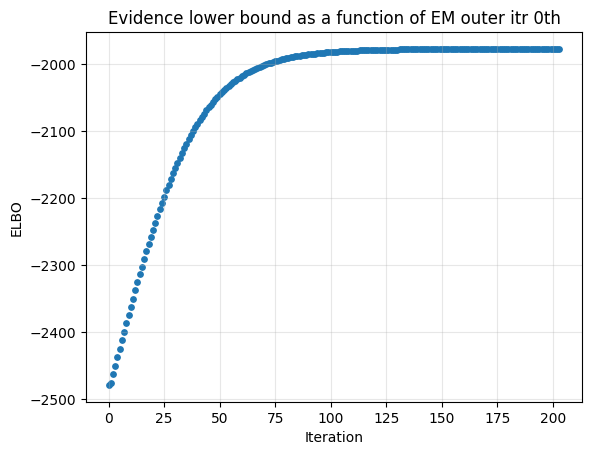

> Generating polygenic scores...


NameError: name 'V_pred' is not defined

In [4]:
np.random.seed(1235)
num_chr = 16
# paths need to be updated for different chr. 
# use to compute LD for training set.
chr_bed_filepath = "CMAll_qced/binary_chr"+str(num_chr)+"/ALL_chr"+str(num_chr)
sumstats_path = "CMAll_qced/binary_chr"+str(num_chr)+"/real_chr"+str(num_chr)+".sumstats"
output_LD_dirpath = "CMAll_qced/binary_chr"+str(num_chr)+"/"   # ld/chr1 would been built there 
ELBO_plot_path = "CMAll_qced/binary_chr"+str(num_chr)+"/ELBO.png"
store_predVal = "CMAll_qced/binary_chr"+str(num_chr)+"/val_predict.npy"
store_predTrain = "CMAll_qced/binary_chr"+str(num_chr)+"/train_predict.npy"
# can use np.load(store_predVal) to get the array 
M_fixed_paras = {'pi':0.05, 'sigma_epsilon':  0.70}

# real_phe for 2706 samples
gdl_chr = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    sumstats_files= "CMAll_qced/binary_chr16/real_chr16.sumstats",  # gwas put here
    sumstats_format= "magenpy",
)


Train_gdl_chr, Val_gdl_chr = gdl_chr.split_by_samples(proportions=[.8, .2])

gdl_train = mgp.GWADataLoader(ld_store_files='CMAll_qced/binary_chr16/ld/chr_16/',
                        sumstats_files='CMAll_qced/binary_chr16/real_chr16.sumstats',
                        sumstats_format='magenpy')

v_chr = vp.VIPRS(gdl_train, fix_params = M_fixed_paras) 
# v = vp.VIPRS(realA22Train_gdl) 
# theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
# v.initialize(theta_0=theta_0)
v_chr.fit()

ELBO_plot(v_chr.history['ELBO'], ELBO_plot_path,itr=0)
Val_pred = v_chr.predict(Val_gdl_chr)
np.save(store_predVal, Val_pred)
# V_pred = V_pred + Val_pred

Train_pred = v_chr.predict(Train_gdl_chr)
np.save(store_predTrain, Train_pred)
# T_pred = T_pred + Train_pred


In [13]:
store_predVal = "CMAll_qced/binary_chr"+str(num_chr)+"/val_predict.npy"
Val_15 = np.load("CMAll_qced/binary_chr15/val_predict.npy") 
Val_16 = np.load("CMAll_qced/binary_chr16/val_predict.npy") 

Sum = Val_15 + Val_16
pearson_r(Sum, Val_gdl_chr.sample_table.phenotype)

-0.057846802151907135

<h3> Train on chr19 add cov. to gwas (Still failed due to plink adding cov) </h3>  

I tried to compute with plink:  
~/RA_Project/CMAll_qced/binary_chr19$ plink --bfile ALL_chr19 --linear --pheno ../DREAM_pheno_Full.txt --covar ../../data/Dosage_for_PCA/NoDos_covHasHeader.csv --covar-name baselineDAS --out sumstats_19_Cov1

Then use the <code>sumstats_19_Cov1.assoc.linear</code> file to add the summary stats file (with covariate baselineDAS) and to do viprs training.  

I tried the method before, but it still not work. 

In [15]:
np.random.seed(1235)
# paths need to be updated for different chr. 
chr_bed_filepath = "CMAll_qced/binary_chr19/ALL_chr19"
# output_LD_dirpath = "CMAll_qced/binary_chr19/"   # ld/chr1 would been built there 
ELBO_plot_path = "Real_phe_expr/ELBO_plots/real_ALL_chr19Cov.png"

# real_phe for 2706 samples
realA22_gdl_19Cov = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    covariates_file= "data/Dosage_for_PCA/NoDos_covHasHeader.csv",
    sumstats_files= "CMAll_qced/binary_chr19/sumstats_19_Cov1.assoc.linear",  # gwas put here
    sumstats_format= "plink",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

realA22Train_gdl_19Cov, realA22Val_gdl_19Cov = realA22_gdl_19Cov.split_by_samples(proportions=[.8, .2])

realA22Train_gdl_19Cov.read_ld("CMAll_qced/binary_chr19/ld/chr_19")





> Reading BED file...
> Reading phenotype file...
> Reading covariates file...
> Reading summary statistics file...
> Harmonizing data...
> Reading LD matrix...


In [32]:
# M_fixed_paras = {'pi': 0.001, 'sigma_epsilon': 0.90}
# v_19Cov = vp.VIPRS(realA22Train_gdl_19Cov, fix_params = M_fixed_paras) 

v_19Cov = vp.VIPRS(realA22Train_gdl_19Cov) 
theta_0 = {'pi': 0.00001, 'sigma_epsilon': 0.790}
v_19Cov.initialize(theta_0=theta_0)

v_19Cov.fit()

> Initializing model parameters


ZeroDivisionError: float division by zero

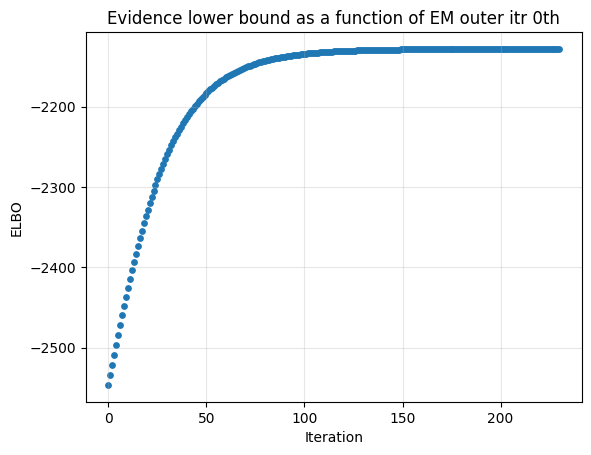

In [17]:
ELBO_plot(v_19Cov.history['ELBO'], ELBO_plot_path,itr=0)


> Generating polygenic scores...
val R: 0.05284213609857501
> Generating polygenic scores...
train R: 0.7217328966927172
the Val_gdl real phe vs. predict phe


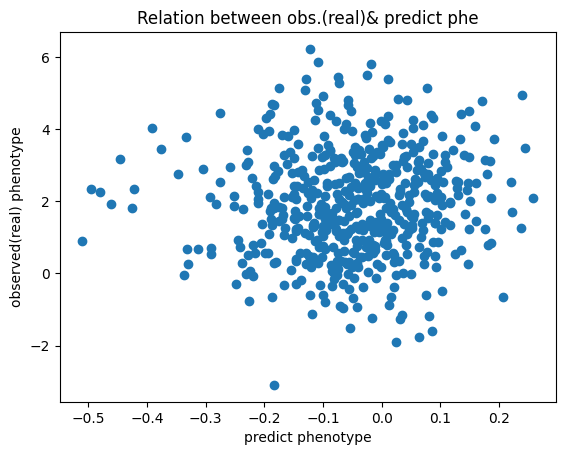

In [18]:
pred = v_19Cov.predict(realA22Val_gdl_19Cov)
print("val R:", pearson_r(pred, realA22Val_gdl_19Cov.sample_table.phenotype))

pred_ytrain = v_19Cov.predict(realA22Train_gdl_19Cov)
print("train R:", pearson_r(pred_ytrain, realA22Train_gdl_19Cov.sample_table.phenotype))

print("the Val_gdl real phe vs. predict phe")
plot_obs_vs_pred(realA22Val_gdl_19Cov.sample_table.phenotype, pred)

<h5>check whether covaraites are adding into it </h5>

Ok, Now I found that the "plink" cannot work for gwas if we want to add covariates file into.  
If I add two covaraites:  "None of [Index(['FIDbaselineDAS', 'IIDAge'], dtype='object')] are in the [columns]"  
If I add more covariates: "operands could not be broadcast together with shapes (2,) (3,) "  

I guess the plink and plink2 new version cannot solve this problem here 

In [3]:
# real_phe for 2706 samples without covariates 
np.random.seed(1235)
chr_bed_filepath = "CMAll_qced/binary_chr19/ALL_chr19"
sumstats_path = "CMAll_qced/binary_chr19/real_chr19.sumstats"

gdl19 = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    backend="plink",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

Train_gdl19, Val_gdl19 = gdl19.split_by_samples(proportions=[.8, .2])

Train_gdl19.perform_gwas()
Train_gdl19.to_summary_statistics_table().to_csv(
    sumstats_path, sep="\t", index=False
)

> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


In [25]:
# real_phe for 2706 samples adding covariates
np.random.seed(1235)

sumstats_path = "CMAll_qced/binary_chr19/real_chr19Cov.sumstats"
gdl_19Cov = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    covariates_file= "data/Dosage_for_PCA/NoDos_NOHead_Cov.csv",
    backend="plink",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

Train_gdl19_Cov, Val_gdl19_Cov = gdl_19Cov.split_by_samples(proportions=[.8, .2])

# realA22Train_gdl_19Cov.read_ld("CMAll_qced/binary_chr19/ld/chr_19")


Train_gdl19_Cov.perform_gwas()
Train_gdl19_Cov.to_summary_statistics_table().to_csv(
    sumstats_path, sep="\t", index=False
)

> Reading BED file...
> Reading phenotype file...
> Reading covariates file...
> Performing GWAS...


ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [24]:
Train_gdl19_Cov.sample_table.covariates

Index(['baselineDAS', 'Age'], dtype='object')

In [22]:
a = pd.read_csv("data/Dosage_for_PCA/NoDos_covHasHeader.csv", sep="\t")
a = a.drop("Sex", axis=1)
a.to_csv("data/Dosage_for_PCA/NoDos_HasHead_baselineAge.csv", sep="\t", index=False)

<h5>change phenotype csv to .txt </h5>
Remove index but has header 

In [7]:
80*1.15

92.0

In [8]:
a = pd.read_csv("data/phenotype_data/DREAM_pheno_Full.csv", sep=" ")
a = a.drop("Unnamed: 0", axis=1)
a.to_csv("CMAll_qced/DREAM_pheno_Full.txt", sep=" ", index=False)
a

,FID,IID,phenotype
0,0,1877000,-2.88
1,0,612000,-2.44
2,0,111000,-2.17
3,0,1780000,-2.11
4,0,825000,-1.97
...,...,...,...
2701,0,2732000,2.76
2702,0,2736000,3.13
2703,0,2744000,3.32
2704,0,2748000,1.59


<h3>Try to use another method to train</h3>

Find some region with important contiguous regions
1. Compute marginal p-value per SNP
2. Choose SNPs with nominal p-value < 0.01 (i.e., a lenient threshold)
3. Center at each significant SNP from step 2 and expand by 1 Mb up and down-stream and include all of the SNPs within the range. Merge the regions that overlap.
4. Compute LD between SNPs within each disjoint region
4. Fit VIPRS only on these regions (one VIPRS model per region)

To get Gwas (the summary statistics data):  <code>
(.venv) yzhu439@nahanni:~/RA_Project/CMAll_qced/binary_chr19$ plink --bfile ALL_chr19 --linear --pheno ../DREAM_pheno_Full.txt --out sumstats_19  </code> this is linear 

In [3]:
sumstats_df =  pd.read_csv('CMAll_qced/binary_chr19/sumstats_19.assoc.linear', sep='\s+')
signif_snps = sumstats_df[sumstats_df['P']<0.001]['SNP']
signif_snps.to_csv("CMAll_qced/binary_chr19/signifi_snps.csv", sep="\t", index = False)
sumstats_df
signif_snps
# signif_snps = sumstats_df[sumstats_df]

2038      rs6510857
2076      rs1678868
2881       rs557094
3785       rs281437
6719      rs2271882
6730      rs2074973
8447     rs17304569
9805       rs184583
10872     rs7252579
14611     rs3213371
17555     rs6509512
19667      rs891186
20696    rs17207593
Name: SNP, dtype: object

<h5> Try to add "baselineDAS" cov into file</h5>

codes:  
at layer <code>"~/RA_Project/CMAll_qced/binary_chr19$"</code>  
plink --bfile ALL_chr19 --linear --pheno ../DREAM_pheno_Full.txt --covar ../../data/Dosage_for_PCA/NoDos_covHasHeader.csv --covar-name baselineDAS --out sumstats_19_Cov1

but if I use this to viprs, it will error, "divided by zero" 

In [30]:
signif_snps = pd.read_csv("CMAll_qced/binary_chr19/signifi_snps.csv", sep="\t")
signif_snps = signif_snps.values.flatten()
signif_snps

array(['rs6510857', 'rs1678868', 'rs557094', 'rs281437', 'rs2271882',
       'rs2074973', 'rs17304569', 'rs184583', 'rs7252579', 'rs3213371',
       'rs6509512', 'rs891186', 'rs17207593'], dtype=object)

In [31]:
dos_19 = pd.read_csv("data/DREAM_RA_Responders_DosageData/Training_chr19.dos" , sep=" ", header=None)
dos_19

,0,1,2,3,4,5,6,7,8,9,...,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711
0,19,rs7247199,253938,A,G,0.417288,0.980000,0.980000,0.070000,0.02,...,0.02,0.97,0.980000,0.980000,0.02,1.98,0.020000,1.880000,0.980000,0.020000
1,19,rs8102643,256859,C,T,0.577342,1.000000,0.983494,1.930000,1.99,...,1.99,1.01,1.000000,0.983494,1.99,0.02,1.980000,0.120000,0.983494,1.990000
2,19,rs8102615,260970,A,T,0.491543,0.990000,0.990000,0.070000,1.00,...,0.01,0.98,0.990000,0.990000,0.01,1.99,0.020000,1.920000,0.990000,0.010000
3,19,rs8105536,261033,A,G,0.423089,0.990000,0.990000,0.070000,0.01,...,0.00,0.98,0.990000,0.990000,0.00,1.99,0.010000,1.920000,0.990000,0.000000
4,19,rs2312724,266034,C,T,0.076717,0.000000,0.000000,0.000000,1.00,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36970,19,rs12462495,59089792,C,T,0.958961,2.000000,2.000000,2.000000,2.00,...,2.00,2.00,2.000000,2.000000,2.00,2.00,2.000000,2.000000,2.000000,2.000000
36971,19,rs1550812,59090423,C,G,0.943193,2.000000,2.000000,2.000000,2.00,...,2.00,2.00,2.000000,2.000000,2.00,2.00,2.000000,2.000000,1.880000,2.000000
36972,19,rs10448,59093239,C,T,0.540108,1.010000,2.000000,1.110000,0.01,...,2.00,2.00,1.040000,2.000000,0.01,2.00,0.990000,0.990000,0.360000,1.020000
36973,19,rs3499,59093484,G,T,0.470059,0.990000,0.000000,0.990000,1.99,...,0.00,0.00,0.990000,0.000000,1.99,0.00,0.990000,0.990000,1.650000,0.990000


In [32]:

# Define the range +- 3Mbp
def snp_range(Sigsnp_loc):
    max_value = Sigsnp_loc + 3e6
    min_value = Sigsnp_loc - 3e6
    indices = dos_19[(dos_19[2] >= min_value) & (dos_19[2] <= max_value)].index
    indices = np.array(indices)
    return indices

regions_inds = []
    
for snp in signif_snps:
    Loc = dos_19[dos_19[1] == snp][2].values     # eg. array([5800273])
    if Loc.tolist() == []:
        continue
    inds = snp_range(Loc[0])
    regions_inds.append(inds)
# Create an array of indices that would 
# sort the list based on the first element of each array
sorted_indices = np.argsort([arr[0] for arr in regions_inds])

# Sort the list of arrays using the sorted indices
sorted_regions_inds = [regions_inds[i] for i in sorted_indices]

sorted_regions_inds



[array([1324, 1325, 1326, ..., 4964, 4965, 4966]),
 array([1398, 1399, 1400, ..., 4993, 4994, 4995]),
 array([2459, 2460, 2461, ..., 6131, 6132, 6133]),
 array([4073, 4074, 4075, ..., 7329, 7330, 7331]),
 array([ 8510,  8511,  8512, ..., 12144, 12145, 12146]),
 array([ 8514,  8515,  8516, ..., 12166, 12167, 12168]),
 array([12107, 12108, 12109, ..., 14004, 14005, 14006]),
 array([14007, 14008, 14009, ..., 19153, 19154, 19155]),
 array([16260, 16261, 16262, ..., 21140, 21141, 21142]),
 array([24069, 24070, 24071, ..., 27720, 27721, 27722]),
 array([31697, 31698, 31699, ..., 36732, 36733, 36734]),
 array([33451, 33452, 33453, ..., 36972, 36973, 36974])]

In [33]:
# init used regions
regions_inds_used = [sorted_regions_inds[0]]

for i in range(1, len(sorted_regions_inds)):
    check_integer = sorted_regions_inds[i][0]  # the strat ele of next array, check whether overlap with previous region
    exists = np.any(regions_inds_used[-1] == check_integer)
    if exists:
        # need to merge two arrays
        merged_region = np.union1d(regions_inds_used[-1], sorted_regions_inds[i])
        regions_inds_used[-1] = merged_region
    else:
        regions_inds_used.append(sorted_regions_inds[i])

regions_inds_used


[array([1324, 1325, 1326, ..., 7329, 7330, 7331]),
 array([ 8510,  8511,  8512, ..., 14004, 14005, 14006]),
 array([14007, 14008, 14009, ..., 21140, 21141, 21142]),
 array([24069, 24070, 24071, ..., 27720, 27721, 27722]),
 array([31697, 31698, 31699, ..., 36972, 36973, 36974])]

In [34]:
for i, arr in enumerate(regions_inds_used):
    selected_snps = dos_19.iloc[regions_inds_used[i]][1]
    chr_filename = "CMAll_qced/binary_chr19/region_snps/"+ str(i)+ ".txt"
    selected_snps.to_csv(chr_filename, header=False,
                      index=False, sep="\t")




<h5> Then run viprs for all regions and added the result of pre together </h5>

1. Run ~/RA_Project/CMAll_qced$ ./extract_regions_Chr19.sh

2. fit viprs on each regions respectivley,  and then add predict results together. 

In [35]:
Train_pred = np.zeros(2178)
Val_pred = np.zeros(528)

for i in range(0, len(regions_inds_used)):
    np.random.seed(1235)
    # paths need to be updated for different chr. 
    # use to compute LD for training set.
    chr_bed_filepath = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/region"+str(i)
    sumstats_path = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/region"+str(i)+".sumstats"
    output_LD_dirpath = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/"   # ld/chr1 would been built there 
    ELBO_plot_path = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/elbo.png"
    M_fixed_paras = {'pi':0.011, 'sigma_epsilon':  0.60}

    # real_phe for 2706 samples
    region_gdl = mgp.GWADataLoader(
        bed_files = chr_bed_filepath,
        # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
        phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    )
    #"Toy_example_expr/phenotype/shuffle500_phe.csv"

    Train_region_gdl, Val_region_gdl = region_gdl.split_by_samples(proportions=[.8, .2])

    Train_region_gdl.perform_gwas()
    Train_region_gdl.to_summary_statistics_table().to_csv(
        sumstats_path, sep="\t", index=False
    )


    Train_region_gdl.compute_ld(estimator='sample',
                    output_dir=output_LD_dirpath)
    
    v_reg = vp.VIPRS(Train_region_gdl, fix_params = M_fixed_paras ) # 
    # v = vp.VIPRS(realA22Train_gdl) 
    # theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
    # v.initialize(theta_0=theta_0)
    v_reg.fit()

    ELBO_plot(v_reg.history['ELBO'], ELBO_plot_path,itr=0)
    reg_valPred = v_reg.predict(Val_region_gdl)
    reg_trainPred = v_reg.predict(Train_region_gdl)

    Val_pred = Val_pred + reg_valPred
    Train_pred = Train_pred + reg_trainPred


> Reading BED file...
> Reading phenotype file...
> Performing GWAS...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Computing LD matrix...


/home/mcb/users/yzhu439/RA_Project/.venv/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


  0%|          | 4/1000 [00:00<01:15, 13.22it/s]


OptimizationDivergence: Stopping at iteration 5: The optimization algorithm is not converging!
Previous ELBO: -462.251640 | Current ELBO: 1083.189843

In [ ]:
Train_pred = np.zeros(2178)
Val_pred = np.zeros(528)

print("chr 19 val R:", pearson_r(Val_pred, Val_region_gdl.sample_table.phenotype))

print("train R:", pearson_r(Train_pred, Train_region_gdl.sample_table.phenotype))

print("the Val_gdl real phe vs. predict phe")
plot_obs_vs_pred(Val_region_gdl.sample_table.phenotype, Val_pred)

<h3>Try to use another method to Chr1 </h3>

Find some region with important contiguous regions
1. Compute marginal p-value per SNP
2. Choose SNPs with nominal p-value < 0.01 (i.e., a lenient threshold)
3. Center at each significant SNP from step 2 and expand by 1 Mb up and down-stream and include all of the SNPs within the range. Merge the regions that overlap.
4. Compute LD between SNPs within each disjoint region
4. Fit VIPRS only on these regions (one VIPRS model per region)

To get Gwas (the summary statistics data):  <code>
(.venv) yzhu439@nahanni:~/RA_Project/CMAll_qced/binary_chr1$ plink --bfile ALL_chr1 --linear --pheno ../DREAM_pheno_Full.txt --out sumstats_1  </code> this is linear 

In [37]:

sumstats_df =  pd.read_csv('CMAll_qced/binary_chr1/sumstats_1.assoc.linear', sep='\s+')
signif_snps = sumstats_df[sumstats_df['P']<0.01]['SNP']
signif_snps.to_csv("CMAll_qced/binary_chr1/signifi_snps.csv", sep="\t", index = False)
# sumstats_df
print("stored", signif_snps)

signif_snps = pd.read_csv("CMAll_qced/binary_chr1/signifi_snps.csv", sep="\t")
signif_snps = signif_snps.values.flatten()
signif_snps

stored 415        rs2495368
481        rs7340016
496        rs2842909
671        rs6670328
680       rs12409345
             ...    
102376     rs3129539
102403    rs12045922
102726    rs10802494
102837    rs12130442
102905     rs2640034
Name: SNP, Length: 1236, dtype: object


array(['rs2495368', 'rs7340016', 'rs2842909', ..., 'rs10802494',
       'rs12130442', 'rs2640034'], dtype=object)

In [38]:
dos_1 = pd.read_csv("data/DREAM_RA_Responders_DosageData/Training_chr1.dos" , sep=" ", header=None)
dos_1

,0,1,2,3,4,5,6,7,8,9,...,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711
0,1,rs12565286,721290,C,G,0.070407,0.05,0.30,0.14,0.05,...,0.05,0.30,0.05,0.31,0.05,0.33,0.39,0.05,0.05,0.05
1,1,rs11804171,723819,A,T,0.071072,0.05,0.31,0.14,0.05,...,0.05,0.30,0.05,0.31,0.05,0.34,0.40,0.05,0.05,0.05
2,1,rs2977670,723891,C,G,0.926689,1.95,1.69,1.84,1.95,...,1.95,1.68,1.95,1.68,1.95,1.64,1.58,1.95,1.95,1.95
3,1,rs2977656,729948,C,T,0.991485,1.99,1.99,1.98,1.99,...,1.98,2.00,1.99,1.99,1.99,1.99,1.99,1.98,1.98,1.99
4,1,rs3094315,752566,A,G,0.822056,2.00,1.00,1.51,2.00,...,2.00,1.00,2.00,1.00,2.00,1.00,1.00,2.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193244,1,rs12025760,249208153,A,C,0.013219,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00
193245,1,rs12023135,249208615,C,G,0.026525,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00
193246,1,rs4926502,249209140,A,G,0.011754,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.80,0.00
193247,1,rs6704311,249210707,A,G,0.055872,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [39]:

# Define the range +- 3Mbp
def snp_range(Sigsnp_loc,dos_df):
    max_value = Sigsnp_loc + 1e6
    min_value = Sigsnp_loc - 1e6
    indices = dos_df[(dos_df[2] >= min_value) & (dos_df[2] <= max_value)].index
    indices = np.array(indices)
    return indices

regions_inds = []

for snp in signif_snps:
    Loc = dos_1[dos_1[1] == snp][2].values     # eg. array([5800273])
    if Loc.tolist() == []:
        continue
    inds = snp_range(Loc[0], dos_1)
    regions_inds.append(inds)
# Create an array of indices that would 
# sort the list based on the first element of each array
sorted_indices = np.argsort([arr[0] for arr in regions_inds])

# Sort the list of arrays using the sorted indices
sorted_regions_inds = [regions_inds[i] for i in sorted_indices]

sorted_regions_inds

[array([ 127,  128,  129, ..., 1219, 1220, 1221]),
 array([ 206,  207,  208, ..., 1524, 1525, 1526]),
 array([ 350,  351,  352, ..., 1824, 1825, 1826]),
 array([ 364,  365,  366, ..., 1832, 1833, 1834]),
 array([ 372,  373,  374, ..., 1858, 1859, 1860]),
 array([ 577,  578,  579, ..., 2770, 2771, 2772]),
 array([ 963,  964,  965, ..., 3487, 3488, 3489]),
 array([1129, 1130, 1131, ..., 3689, 3690, 3691]),
 array([1957, 1958, 1959, ..., 4820, 4821, 4822]),
 array([1981, 1982, 1983, ..., 4826, 4827, 4828]),
 array([2022, 2023, 2024, ..., 4841, 4842, 4843]),
 array([2034, 2035, 2036, ..., 4841, 4842, 4843]),
 array([2704, 2705, 2706, ..., 4970, 4971, 4972]),
 array([2893, 2894, 2895, ..., 5035, 5036, 5037]),
 array([3095, 3096, 3097, ..., 5130, 5131, 5132]),
 array([3201, 3202, 3203, ..., 5178, 5179, 5180]),
 array([3208, 3209, 3210, ..., 5182, 5183, 5184]),
 array([3363, 3364, 3365, ..., 5252, 5253, 5254]),
 array([3375, 3376, 3377, ..., 5261, 5262, 5263]),
 array([4546, 4547, 4548, ..., 

In [40]:
# init used regions
regions_inds_used = [sorted_regions_inds[0]]

for i in range(1, len(sorted_regions_inds)):
    check_integer = sorted_regions_inds[i][0]  # the strat ele of next array, check whether overlap with previous region
    exists = np.any(regions_inds_used[-1] == check_integer)
    if exists:
        # need to merge two arrays
        merged_region = np.union1d(regions_inds_used[-1], sorted_regions_inds[i])
        regions_inds_used[-1] = merged_region
    else:
        regions_inds_used.append(sorted_regions_inds[i])

regions_inds_used

[array([  127,   128,   129, ..., 37291, 37292, 37293]),
 array([ 37648,  37649,  37650, ..., 101418, 101419, 101420]),
 array([101463, 101464, 101465, ..., 102757, 102758, 102759]),
 array([102818, 102819, 102820, ..., 124498, 124499, 124500]),
 array([124590, 124591, 124592, ..., 139019, 139020, 139021]),
 array([139431, 139432, 139433, ..., 193119, 193120, 193121])]

In [49]:

for i in range(0, len(regions_inds_used)):
    print("num snps in this region", len(regions_inds_used[i]) )

# but actually extracted is less than those. 
# Actually Extract : 18609, 29081, 556 , 10431, 6400, 25315

num snps in this region 37167
num snps in this region 63773
num snps in this region 1297
num snps in this region 21683
num snps in this region 14432
num snps in this region 53691


In [51]:
# remember to create the folder "region_snps" firstly!!

for i, arr in enumerate(regions_inds_used):
    selected_snps = dos_1.iloc[regions_inds_used[i]][1]
    chr_filename = "CMAll_qced/binary_chr1/region_snps/"+ str(i)+ ".txt"
    selected_snps.to_csv(chr_filename, header=False,
                      index=False, sep="\t")



<h5> Then run viprs one region and added the result of pre together for chr1</h5>

1. Run ~/RA_Project/CMAll_qced$ ./extract_regions_Chr1.sh

2. Try viprs on 0, 1

In [ ]:
# chr1 region0 
np.random.seed(1235)
# paths need to be updated for different chr. 
# use to compute LD for training set.
i = 0 # region
chr_bed_filepath = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/region"+str(i)
sumstats_path = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/region"+str(i)+".sumstats"
output_LD_dirpath = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/"   # ld/chr1 would been built there 
ELBO_plot_path = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/elbo.png"
M_fixed_paras = {'pi':0.01, 'sigma_epsilon':  0.95}

# real_phe for 2706 samples
region_gdl = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"

Train_region_gdl, Val_region_gdl = region_gdl.split_by_samples(proportions=[.8, .2])

Train_region_gdl.perform_gwas()
Train_region_gdl.to_summary_statistics_table().to_csv(
    sumstats_path, sep="\t", index=False
)


Train_region_gdl.compute_ld(estimator='sample',
                output_dir=output_LD_dirpath)

v_reg = vp.VIPRS(Train_region_gdl, fix_params = M_fixed_paras ) # 
# v = vp.VIPRS(realA22Train_gdl) 
# theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
# v.initialize(theta_0=theta_0)
v_reg.fit()

ELBO_plot(v_reg.history['ELBO'], ELBO_plot_path,itr=0)


: 

What I tried to do below??  
I input the gwas summary file and read the ld, the sumstats_format is magenpy, and still use the backend = "xarray" ?

In [3]:
# chr1 region0 , directly read 
np.random.seed(1235)
# paths need to be updated for different chr. 
# use to compute LD for training set.
i = 0 # region
chr_bed_filepath = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/region"+str(i)
sumstats_path = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/region"+str(i)+".sumstats"
output_LD_dirpath = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/"   # ld/chr1 would been built there 
ELBO_plot_path = "CMAll_qced/binary_chr1/region_snps/region"+str(i)+"/elbo.png"
M_fixed_paras = {'pi':0.03, 'sigma_epsilon':  0.70}


# real_phe for 2706 samples
region_gdl = mgp.GWADataLoader(
    bed_files = chr_bed_filepath,
    # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
    phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    sumstats_files= "CMAll_qced/binary_chr1/region_snps/region0/region0.sumstats",  # gwas put here
    sumstats_format= "magenpy",
)
#"Toy_example_expr/phenotype/shuffle500_phe.csv"


Train_region_gdl, Val_region_gdl = region_gdl.split_by_samples(proportions=[.8, .2])



Train_region_gdl.read_ld("CMAll_qced/binary_chr1/region_snps/region0/ld/chr_1")


v_reg = vp.VIPRS(Train_region_gdl, fix_params = M_fixed_paras ) # 
# v = vp.VIPRS(realA22Train_gdl) 
# theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
# v.initialize(theta_0=theta_0)
v_reg.fit()

ELBO_plot(v_reg.history['ELBO'], ELBO_plot_path,itr=0)

> Reading BED file...
> Reading phenotype file...
> Reading summary statistics file...
> Harmonizing data...
> Reading LD matrix...


Exception ignored in: <finalize object at 0x7f3e10601ea0; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 934, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'temp/ld_be6_fr19'


> Initializing model parameters
> Loading LD matrices into memory...
> Performing model fit...
> Using up to 1 threads.


 30%|██▉       | 295/1000 [09:43<23:56,  2.04s/it]

In [ ]:
pred = v_reg.predict(Val_region_gdl)
print("val R:", pearson_r(pred, Val_region_gdl.sample_table.phenotype))

pred_ytrain = v_reg.predict(Train_region_gdl)
print("train R:", pearson_r(pred_ytrain, Train_region_gdl.sample_table.phenotype))

print("the Val_gdl real phe vs. predict phe")
plot_obs_vs_pred(Val_region_gdl.sample_table.phenotype, pred)

In [ ]:
Train_pred = np.zeros(2178)
Val_pred = np.zeros(528)

for i in range(0, len(regions_inds_used)):
    np.random.seed(1235)
    # paths need to be updated for different chr. 
    # use to compute LD for training set.
    chr_bed_filepath = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/region"+str(i)
    sumstats_path = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/region"+str(i)+".sumstats"
    output_LD_dirpath = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/"   # ld/chr1 would been built there 
    ELBO_plot_path = "CMAll_qced/binary_chr19/region_snps/region"+str(i)+"/elbo.png"
    M_fixed_paras = {'pi':0.011, 'sigma_epsilon':  0.60}

    # real_phe for 2706 samples
    region_gdl = mgp.GWADataLoader(
        bed_files = chr_bed_filepath,
        # phenotype_file="data/phenotype_data/DREAM_pheno_Full.csv",
        phenotype_file = "data/phenotype_data/DREAM_pheno_Full.csv",
    )
    #"Toy_example_expr/phenotype/shuffle500_phe.csv"

    Train_region_gdl, Val_region_gdl = region_gdl.split_by_samples(proportions=[.8, .2])

    Train_region_gdl.perform_gwas()
    Train_region_gdl.to_summary_statistics_table().to_csv(
        sumstats_path, sep="\t", index=False
    )


    Train_region_gdl.compute_ld(estimator='sample',
                    output_dir=output_LD_dirpath)
    
    v_reg = vp.VIPRS(Train_region_gdl, fix_params = M_fixed_paras ) # 
    # v = vp.VIPRS(realA22Train_gdl) 
    # theta_0 = {'pi': 0.999945, 'sigma_epsilon': 0.50}
    # v.initialize(theta_0=theta_0)
    v_reg.fit()

    ELBO_plot(v_reg.history['ELBO'], ELBO_plot_path,itr=0)
    reg_valPred = v_reg.predict(Val_region_gdl)
    reg_trainPred = v_reg.predict(Train_region_gdl)

    Val_pred = Val_pred + reg_valPred
    Train_pred = Train_pred + reg_trainPred
